# Setup and imports

Intalling mtcnn

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 26.6MB/s 


Mounting Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Imports

In [ ]:
import cv2
import numpy as np
import os
import glob
from os import path
from os.path import isfile, join
from google.colab.patches import cv2_imshow
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from imutils import paths

Specify drive and dataset directory paths

In [ ]:
ROOT_PATH = '/content/gdrive/My Drive/'
DATASET_PATH = 'Computer Vision/dataset/images/'

Loading images and get dataset informations


In [ ]:
dataset = ROOT_PATH + DATASET_PATH

imagePaths = list(paths.list_images(dataset)) # list all image paths

images = [] # images
boxes = [ [] for _ in range(len(imagePaths))] # bounding boxes

for n in range(0, len(imagePaths)):

  # load image
  image = cv2.imread(imagePaths[n])
  img_h, img_w, _ = image.shape # shape of image
  images.append(image)

  # txt_file path
  txtPath = os.path.splitext(imagePaths[n])[0]+'.txt'

  # bounding box coordinates
  with open(txtPath, 'r') as f:
    for i in f: # for every row

      values = i.split() # mask/no-mask and 4 coords informations

      # Relative values according to YOLO format
      rel_x = float(values[1])
      rel_y = float(values[2])
      rel_width = float(values[3])
      rel_height = float(values[4])

      # Calculating absolute values
      x = int(rel_x * img_w)
      y = int(rel_y * img_h)
      w = int(rel_width * img_w)
      h = int(rel_height * img_h)

      # Calculating 4 points of bounding box
      a = [x - int(w/2), y - int(h/2)]
      b = [x + int(w/2), y - int(h/2)]
      c = [x + int(w/2), y + int(h/2)]
      d = [x - int(w/2), y + int(h/2)]

      # Assign 4 points
      boxes[n].append([a, b, c, d])

# Use MTCNN on dataset

Set MTCNN model

In [ ]:
mtcnn_face_detector_model = MTCNN()

In [ ]:
threshold = 0.8

faces = [ [] for _ in range(len(images))] # faces from boxes per every image
points = [ [] for _ in range(len(images))] # probabilities values per every image
det_boxes = [ [] for _ in range(len(images))] # detected bounding boxes

for n in range(0, len(images)):
  
  image = images[n]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  face_locations = mtcnn_face_detector_model.detect_faces(image)

  if face_locations is None:
    continue
  
  for face_location in face_locations:

    prob = face_location['confidence']

    if prob >= threshold:

      # confidence probability
      points[n].append(prob)

      # box coordinates
      x1, y1, width, height = face_location['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height

      # detected faces
      face = image[y1:y2, x1:x2]
      faces[n].append(face)

      # 4 points of bounding boxes
      a = [x1, y1]
      b = [x2, y1]
      c = [x2, y2]
      d = [x1, y2]

      # assign 4 points
      det_boxes[n].append([a, b, c, d])

# Comparing Ground Truth and MTCNN (showing an example)

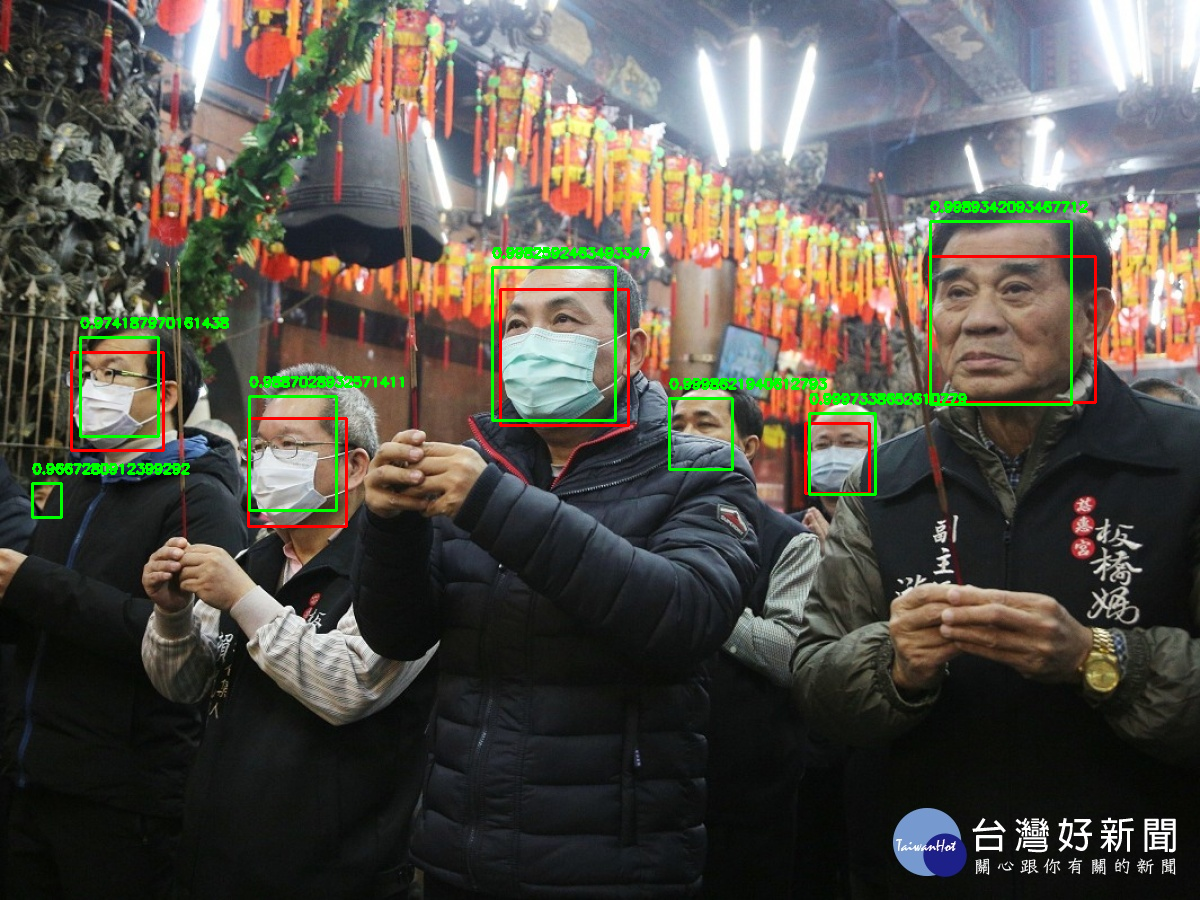

In [ ]:
i = 5
image = images[i].copy()

# true boxes - red
ground_truth = boxes[i]
for true_box in ground_truth:
  a, b, c, d = true_box
  cv2.rectangle(image, tuple(a), tuple(c), (0, 0, 255), 2)

# detected boxes - green
mtcnn_boxes = det_boxes[i]
for mtcnn_box in range(0, len(mtcnn_boxes)):
  a, b, c, d = mtcnn_boxes[mtcnn_box]
  x1 = a[0]
  y1 = a[1]
  cv2.putText(image, str(points[i][mtcnn_box]), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
  cv2.rectangle(image, tuple(a), tuple(c), (0, 255, 0), 2)

cv2_imshow(image)

# Performance Evaluation for Face Detection

In [ ]:
threshold = 0.4

TP = 0
FP = 0
FN = 0

# For every image
for image in range(0, len(images)):

  img = images[n]

  # Copy boxes values
  ground_truth = boxes[image].copy()
  mtcnn_boxes = det_boxes[image].copy()

  color = [255, 255, 255] # white

  # For every bounding box from Ground Truth
  for box in range(0, len(boxes[image])):

    # get ground truth result image
    stencil = np.zeros(images[image].shape).astype(img.dtype)
    contours = np.int32(ground_truth[box])
    cv2.fillPoly(stencil, [contours], color)
    result_gt = cv2.bitwise_and(images[image], stencil)
    result_gt = cv2.cvtColor(result_gt, cv2.COLOR_BGR2RGB)

    # For every bounding box from MTCNN detection
    for det_box in range(0, len(det_boxes[image])):

      if mtcnn_boxes[det_box] == None:
        continue
      
      # get mtcnn detection result image
      stencil = np.zeros(images[image].shape).astype(img.dtype)
      contours = np.int32(mtcnn_boxes[det_box])
      cv2.fillPoly(stencil, [contours], color)
      result_mtcnn = cv2.bitwise_and(images[image], stencil)
      result_mtcnn = cv2.cvtColor(result_mtcnn, cv2.COLOR_BGR2RGB)

      # IoU Calculation
      intersection = np.logical_and(result_gt, result_mtcnn)
      union = np.logical_or(result_gt, result_mtcnn)
      iou_score = np.sum(intersection) / np.sum(union)

      # if IoU >= threshold --> TP += 1
      # remove from Grount Truth, set MTCNN to None
      if iou_score >= threshold:
        TP += 1 # True Positive
        ground_truth[box] = None
        mtcnn_boxes[det_box] = None

  ground_truth = [i for i in ground_truth if i != None]
  mtcnn_boxes = [i for i in mtcnn_boxes if i != None]
  FP += len(mtcnn_boxes) # False Positive if IoU < threshold
  FN += len(ground_truth) # False Negative if no detection

In [ ]:
TP

3648

In [ ]:
FP

758

In [ ]:
FN

1256

In [ ]:
Recall_Score = TP / (FN + TP)
Recall_Score

0.7438825448613376

In [ ]:
Precision_Score = TP / (FP + TP)
Precision_Score

0.8279618701770313

In [ ]:
F1_Score = 2* Precision_Score * Recall_Score/ (Precision_Score + Recall_Score)
F1_Score

0.783673469387755

# Use model resulting from training MobileNetv2 (showing an example)

Load model

In [ ]:
model_path = '/content/gdrive/My Drive/Computer Vision/models/face_mask_12k.h5'
model=load_model(model_path)

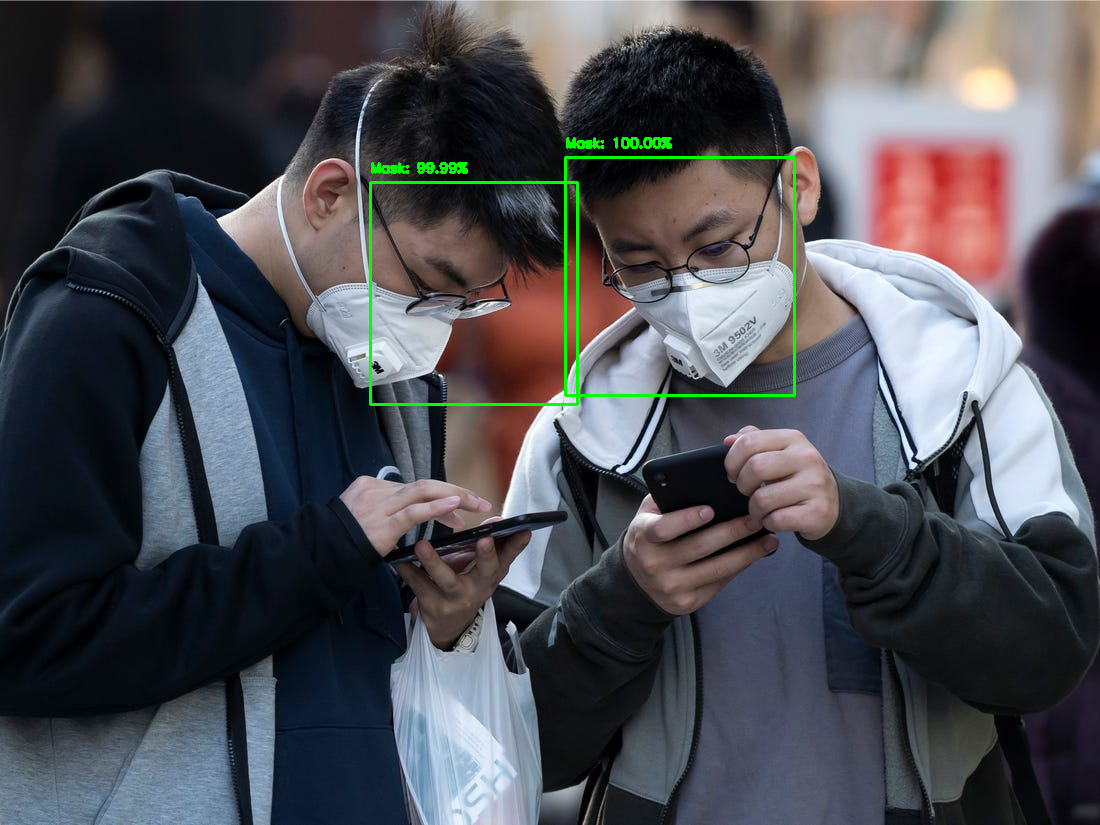

In [ ]:
i = 0
image = images[i].copy()

mtcnn_boxes = det_boxes[i] # mtcnn bounding boxes

for box in mtcnn_boxes:

  a, b, c, d = box # 4 points of box
  
  x1 = d[0]
  y1 = a[1]
  x2 = c[0]
  y2 = d[1]

  # extract the face ROI, convert it from BGR to RGB channel
  # ordering, resize it to 224x224, and preprocess it
  face = image[y1:y2, x1:x2]
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)

  # pass the face through the model to determine if the face
  # has a mask or not
  (mask, withoutMask) = model.predict(face)[0]

  # determine the class label and color we'll use to draw
  # the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

  # include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

  # display the label and bounding box rectangle on the output
  # frame
  cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

cv2_imshow(image)

# Performance evaluation for MobileNetv2

After labelization of the dataset: test set of 100 mask images and 100 non mask images

In [ ]:
FOLDER_PATH = 'Computer Vision/detection_dataset_labeled/'
dataset = ROOT_PATH + FOLDER_PATH

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Testing

In [ ]:
model_path = '/content/gdrive/My Drive/Computer Vision/models/face_mask_12k.h5'
model=load_model(model_path)

In [ ]:
testX = data
testY = labels

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    WithMask       0.75      0.93      0.83       100
 WithoutMask       0.91      0.69      0.78       100

    accuracy                           0.81       200
   macro avg       0.83      0.81      0.81       200
weighted avg       0.83      0.81      0.81       200



In [ ]:
model.evaluate(testX, testY)

7/7 [==============================] - 7s 879ms/step - loss: 0.5873 - accuracy: 0.8100


[0.5873170495033264, 0.8100000023841858]